#  Предсказание температуры расплава стали для ООО «Так закаляем сталь»


## Задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.


## Описание этапа обработки 

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).


## Описание данных 

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## План работы 

**Предобработка данных, исследовательский анализ:** 
- преобразование типов данных где необходимо
- удаление лишних временных меток
- обработка пропусков и выбросов
- анализ событий в течение одного цикла плавки, посчитать информацию по партиям
- оставить только необходимые для обучения признаки 
- посчитать дополнительные признаки, которые помогут модели лучше обучиться
- объединить необходимые данные в одну таблицу, мерджить по ключам (key)

**Подготовка данных для модели:**
- разделить датасет на тестовую и валидационную выборки
- проверить равномерность выборок

**Построение модели:**
- выявить пулл подходов с помощью lazypredict, и найти регрессионную модель, удовлетворяющую необходимым характеристикам 
- обучить несколько моделей регрессии и сравнить качество предсказаний
- найти факторы важности наилучшей модели
- получить MAE < 6.0

**Заключение:**
- проанализировать результаты 
- оформить выводы
- составить отчёт о проделанной работе!

## Изучение данных

In [1]:
!pip3 install catboost 

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor 
from catboost import CatBoostRegressor

In [3]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_arc.name = 'data_arc'

data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk.name = 'data_bulk'

data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_bulk_time.name = 'data_bulk_time'

data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_gas.name = 'data_gas'

data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_temp.name = 'data_temp'

data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire.name = 'data_wire'

data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
data_wire_time.name = 'data_wire_time'

In [4]:
data_all = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]

In [5]:
for df in data_all:
    display(df.info())
    display(df.head())
    print('____________________________')
    print('\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


____________________________


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


____________________________


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


____________________________


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


____________________________


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


____________________________


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


____________________________


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


____________________________




**Предоставленные данные имеют следующие аномалии, которые бросаются в глаза:**

Пропуски значений в столбцах. В основном это data_bulk и data_wire, где каждый столбец соответствует определенному легируемому материалу. NaNы в данном случае заменяем нулями, потому что они (материалы) не были добавлены.

Несоответсвующий тип данных. Есть столбцы, которые могут не использовать тип float, так как хранят только целые числа. Или столбцы с датой, но с типом данных object. Их надо перевести в формат datetime.

Разноязычные названия столбцов. Имена столбцов нужно превести к одному формату и без пробелов. 

## Предобработка данных


Меняем имена столбцов.

In [6]:
data_arc.rename(columns={'Начало нагрева дугой': 'time_start',
                                    'Конец нагрева дугой': 'time_end',
                                    'Активная мощность': 'active_power',
                                    'Реактивная мощность': 'reactive_power'}, inplace=True)

data_temp.rename(columns={'Время замера': 'time_temperature',
                                      'Температура': 'temperature'}, inplace=True)

data_gas.rename(columns={'Газ 1': 'gas'}, inplace=True)

Переводим формат даты в datetime.

In [7]:
data_arc['time_start']=pd.to_datetime(data_arc['time_start'])
data_arc['time_end']=pd.to_datetime(data_arc['time_end'])
data_temp['time_temperature']=pd.to_datetime(data_temp['time_temperature'])

Посмотрим на распределение активной и реактивной мощностей, и проверим их на наличие выбросов.

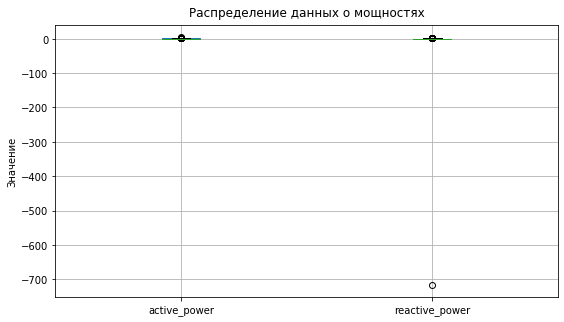

In [8]:
plt.figure(figsize=(9,5))
data_arc.boxplot(['active_power','reactive_power'])
plt.title('Распределение данных о мощностях', y=1.01)
plt.ylabel('Значение')
plt.show()

Аномальное значение реактивной мощности. Скорее ошибочное значение, поэтому удалим его из таблицы.

In [9]:
data_arc[data_arc['reactive_power']<-100]
data_arc=data_arc[data_arc['reactive_power']>-100]

Посмотрим на распределение мощностей.

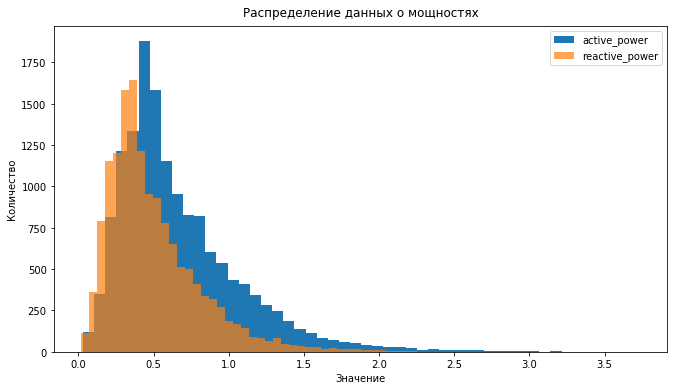

In [10]:
plt.figure(figsize=(11,6))
data_arc['active_power'].plot(kind='hist', bins=50, legend=True)
data_arc['reactive_power'].plot(kind='hist', bins=50, legend=True, alpha=0.7)
plt.title('Распределение данных о мощностях', y=1.01)
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

Оставляем пока две мощности, на корреляционной матрице посмотрим, что больше подойдет для обучения.

Теперь определим первую и последнюю замеры теператур.

In [11]:
data_temp.head()

,key,time_temperature,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [12]:
data_temp_pivot = data_temp.pivot_table(index='key', aggfunc=['max','min'])
data_temp_pivot=data_temp_pivot.reset_index()
data_temp_pivot.columns=['key', 'temp_end', 'time_temperature', 'temp_start', 'start_time_temperature']
data_temp_pivot.head()

,key,temp_end,time_temperature,temp_start,start_time_temperature
0,1,1618.0,2019-05-03 11:30:39,1571.0,2019-05-03 11:16:18
1,2,1608.0,2019-05-03 11:59:12,1577.0,2019-05-03 11:37:27
2,3,1599.0,2019-05-03 12:34:57,1596.0,2019-05-03 12:13:17
3,4,1625.0,2019-05-03 12:59:25,1601.0,2019-05-03 12:52:57
4,5,1602.0,2019-05-03 13:36:01,1576.0,2019-05-03 13:23:19


Удалим столбец "temp_end", так как присвоенные данные по последнему замеру температуры не соответствуют своему времени если были допущены пропуски. НО! Потом добавим температуру последнего замера по значению ключа и времени.

In [13]:
data_temp_pivot= data_temp_pivot.drop(columns=['temp_end'])
data_temp_pivot.head()

,key,time_temperature,temp_start,start_time_temperature
0,1,2019-05-03 11:30:39,1571.0,2019-05-03 11:16:18
1,2,2019-05-03 11:59:12,1577.0,2019-05-03 11:37:27
2,3,2019-05-03 12:34:57,1596.0,2019-05-03 12:13:17
3,4,2019-05-03 12:59:25,1601.0,2019-05-03 12:52:57
4,5,2019-05-03 13:36:01,1576.0,2019-05-03 13:23:19


In [14]:
data_temp_pivot=data_temp_pivot.merge(data_temp, on=['key','time_temperature'], how='left')
data_temp_pivot

,key,time_temperature,temp_start,start_time_temperature,temperature
0,1,2019-05-03 11:30:39,1571.0,2019-05-03 11:16:18,1613.0
1,2,2019-05-03 11:59:12,1577.0,2019-05-03 11:37:27,1602.0
2,3,2019-05-03 12:34:57,1596.0,2019-05-03 12:13:17,1599.0
3,4,2019-05-03 12:59:25,1601.0,2019-05-03 12:52:57,1625.0
4,5,2019-05-03 13:36:01,1576.0,2019-05-03 13:23:19,1602.0
...,...,...,...,...,...
3211,3237,2019-08-31 23:05:43,1569.0,2019-08-31 22:44:04,NaN
3212,3238,2019-08-31 23:43:00,1584.0,2019-08-31 23:30:31,NaN
3213,3239,2019-09-01 02:24:15,1598.0,2019-09-01 01:31:47,NaN
3214,3240,2019-09-01 03:35:16,1617.0,2019-09-01 02:39:01,NaN


In [15]:
data_temp_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 5 columns):
key                       3216 non-null int64
time_temperature          3216 non-null datetime64[ns]
temp_start                3216 non-null float64
start_time_temperature    3216 non-null datetime64[ns]
temperature               2477 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 150.8 KB


Мы видим пропущенные значения в целевом признаке "temperature", мы эти данные никак не узнаем, ни через среднее, ни через медиану, пооэтому просто удалим строки без замеренных данных по температуре.

In [16]:
data_temp_pivot=data_temp_pivot.dropna(subset=['temperature'])

In [17]:
data_temp_pivot.columns = ['key', 'time_temperature', 'temp_start', 'start_time_temperature', 'temperature']
data_temp_pivot

,key,time_temperature,temp_start,start_time_temperature,temperature
0,1,2019-05-03 11:30:39,1571.0,2019-05-03 11:16:18,1613.0
1,2,2019-05-03 11:59:12,1577.0,2019-05-03 11:37:27,1602.0
2,3,2019-05-03 12:34:57,1596.0,2019-05-03 12:13:17,1599.0
3,4,2019-05-03 12:59:25,1601.0,2019-05-03 12:52:57,1625.0
4,5,2019-05-03 13:36:01,1576.0,2019-05-03 13:23:19,1602.0
...,...,...,...,...,...
2472,2495,2019-08-06 00:54:42,1570.0,2019-08-06 00:35:45,1591.0
2473,2496,2019-08-06 01:29:52,1554.0,2019-08-06 01:02:54,1591.0
2474,2497,2019-08-06 01:53:50,1571.0,2019-08-06 01:41:53,1589.0
2475,2498,2019-08-06 02:25:31,1570.0,2019-08-06 02:03:49,1594.0


Готово. Данные стали чище на 739 строк.

Выведем распределение значения целевого признака на график.

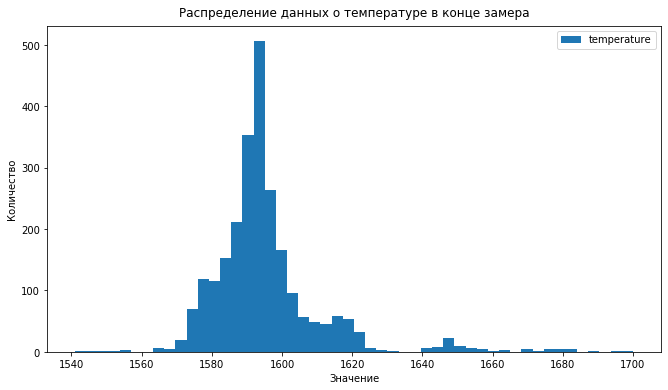

In [18]:
plt.figure(figsize=(11,6))
data_temp_pivot['temperature'].plot(kind='hist', bins=50, legend=True)
plt.title('Распределение данных о температуре в конце замера', y=1.01)
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

Посмотрим визульно на распределение данных в нашей таблице при помощи pairplot

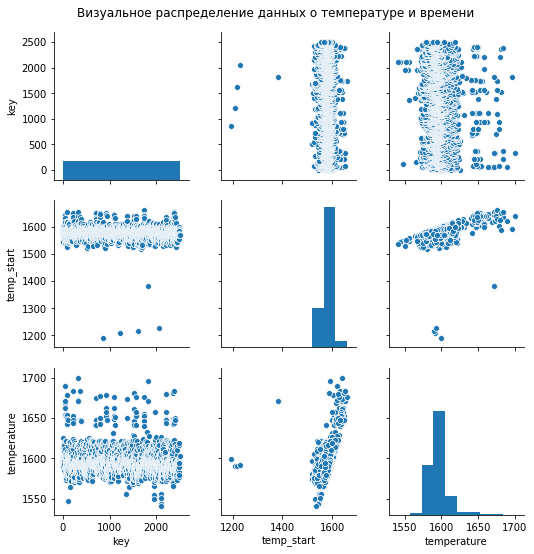

In [19]:
sns.pairplot(data_temp_pivot, diag_kind="hist")
plt.suptitle("Визуальное распределение данных о температуре и времени", y=1.02, fontsize=12)
plt.show()

Видим, что в каждой партии температура в начале замера находится в одном диапазоне, в конце же этот диапазон расширяется (температура может быть совершенно различной). Это и есть выбивающиеся значения.

Чтобы модель лучше обучилась, добавим новые фичи. Найдем длительность времени между первым и последним замером температуры, суммарное время нагрева электродами (сумма значений по всем промежуткам между запусками нагрева электродов), количество запусков нагрева электродами, среднее соотношение потребления активной и реактивной мощности.

Начнем с длительности времени между первым и последним замером температуры.

In [20]:
first_last_temp=data_temp.groupby('key')['time_temperature'].agg({max,min})
first_last_temp=first_last_temp.reset_index()
first_last_temp.columns=['key', 'time_temperature','start_time_temperature']
first_last_temp

,key,time_temperature,start_time_temperature
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19
...,...,...,...
3211,3237,2019-08-31 23:05:43,2019-08-31 22:44:04
3212,3238,2019-08-31 23:43:00,2019-08-31 23:30:31
3213,3239,2019-09-01 02:24:15,2019-09-01 01:31:47
3214,3240,2019-09-01 03:35:16,2019-09-01 02:39:01


In [21]:
first_last_temp['temperature_difference'] = first_last_temp['time_temperature'] - first_last_temp['start_time_temperature']
first_last_temp

,key,time_temperature,start_time_temperature,temperature_difference
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18,00:14:21
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27,00:21:45
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17,00:21:40
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57,00:06:28
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19,00:12:42
...,...,...,...,...
3211,3237,2019-08-31 23:05:43,2019-08-31 22:44:04,00:21:39
3212,3238,2019-08-31 23:43:00,2019-08-31 23:30:31,00:12:29
3213,3239,2019-09-01 02:24:15,2019-09-01 01:31:47,00:52:28
3214,3240,2019-09-01 03:35:16,2019-09-01 02:39:01,00:56:15


Далее, суммарное время нагрева электродами.

In [22]:
data_arc2 = data_arc.copy()
data_arc2['heating_time'] = data_arc2['time_end']-data_arc2['time_start']
data_arc2

,key,time_start,time_end,active_power,reactive_power,heating_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,00:02:28
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,00:02:37
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,00:03:00
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,00:03:04
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,00:00:57


Найдём суммарное время нагрева электродами по каждому ключу.

In [23]:
time_per_key= data_arc2.groupby('key')['heating_time'].sum()
time_per_key=time_per_key.reset_index()
time_per_key.columns=['key','heating_time_sum']
time_per_key

,key,heating_time_sum
0,1,00:18:18
1,2,00:13:31
2,3,00:10:55
3,4,00:12:21
4,5,00:14:29
...,...,...
3209,3237,00:15:09
3210,3238,00:09:06
3211,3239,00:20:16
3212,3240,00:13:59


Переходим к количеству запусков нагрева электродами.

In [24]:
count_heating = data_arc2.groupby('key')['heating_time'].count()
count_heating=count_heating.reset_index()
count_heating.columns = ['key','heating_time_count']
count_heating

,key,heating_time_count
0,1,5
1,2,4
2,3,5
3,4,4
4,5,4
...,...,...
3209,3237,5
3210,3238,3
3211,3239,8
3212,3240,5


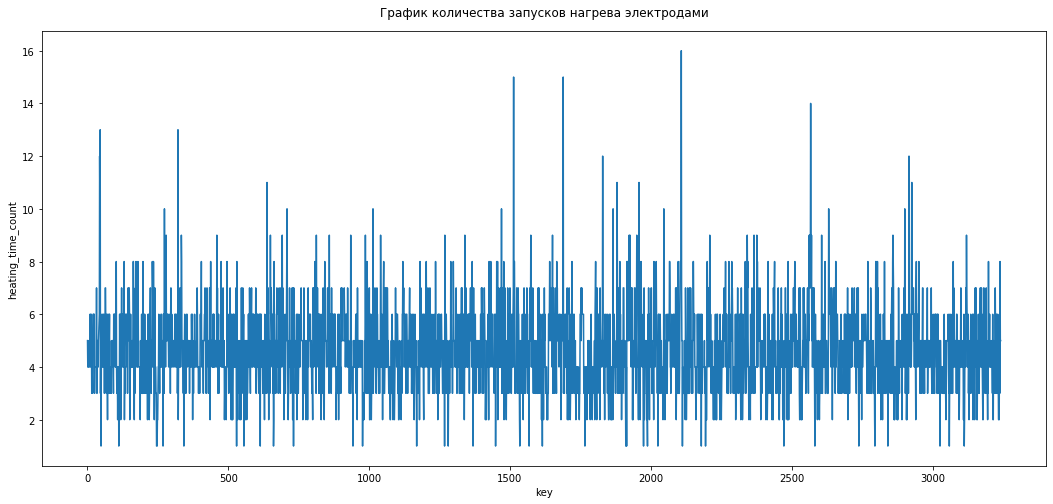

In [25]:
plt.figure(figsize=(18,8))
sns.lineplot(data=count_heating, x='key',y='heating_time_count')
plt.title('График количества запусков нагрева электродами', y=1.02)
plt.show()

И наконец, среднее соотношение потребления активной и реактивной мощности.

In [26]:
mean_ratio_power = data_arc2.groupby('key')['active_power','reactive_power'].mean()
mean_ratio_power = mean_ratio_power.reset_index()
mean_ratio_power.columns=['key','active_power_mean','reactive_power_mean']
mean_ratio_power['active_power\reactive_power'] = mean_ratio_power['active_power_mean']/mean_ratio_power['reactive_power_mean']
mean_ratio_power

,key,active_power_mean,reactive_power_mean,active_power\reactive_power
0,1,0.975629,0.636648,1.532447
1,2,0.763150,0.499528,1.527741
2,3,0.505176,0.319815,1.579589
3,4,0.802313,0.515074,1.557663
4,5,0.836793,0.563161,1.485887
...,...,...,...,...
3209,3237,0.786493,0.565692,1.390321
3210,3238,0.702176,0.560394,1.253004
3211,3239,0.583344,0.388952,1.499784
3212,3240,0.596817,0.496653,1.201676


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


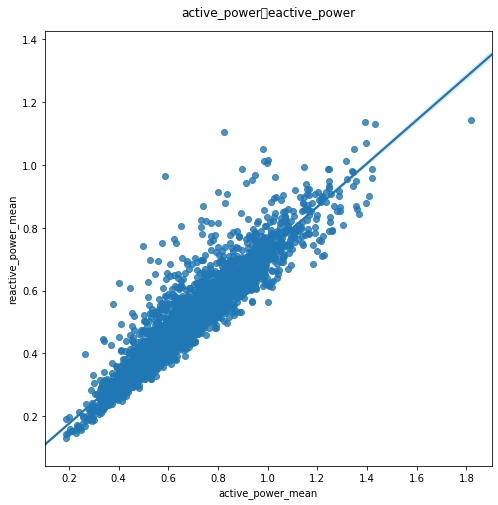

In [27]:
plt.figure(figsize=(8,8))
sns.regplot(x="active_power_mean", y="reactive_power_mean", data=mean_ratio_power)
plt.title('active_power\reactive_power',y=1.02)
plt.show()

Объеденим все полученные столбцы с основной таблицей. Мержить будем по ключу.

In [28]:
table = time_per_key.merge(count_heating ,on='key')
table.head()

,key,heating_time_sum,heating_time_count
0,1,00:18:18,5
1,2,00:13:31,4
2,3,00:10:55,5
3,4,00:12:21,4
4,5,00:14:29,4


In [29]:
table = table.merge(mean_ratio_power ,on='key')
table.head()

,key,heating_time_sum,heating_time_count,active_power_mean,reactive_power_mean,active_power\reactive_power
0,1,00:18:18,5,0.975629,0.636648,1.532447
1,2,00:13:31,4,0.763150,0.499528,1.527741
2,3,00:10:55,5,0.505176,0.319815,1.579589
3,4,00:12:21,4,0.802313,0.515074,1.557663
4,5,00:14:29,4,0.836793,0.563161,1.485887


In [30]:
table = table.merge(first_last_temp, on='key')
table.head()

,key,heating_time_sum,heating_time_count,active_power_mean,reactive_power_mean,active_power\reactive_power,time_temperature,start_time_temperature,temperature_difference
0,1,00:18:18,5,0.975629,0.636648,1.532447,2019-05-03 11:30:39,2019-05-03 11:16:18,00:14:21
1,2,00:13:31,4,0.763150,0.499528,1.527741,2019-05-03 11:59:12,2019-05-03 11:37:27,00:21:45
2,3,00:10:55,5,0.505176,0.319815,1.579589,2019-05-03 12:34:57,2019-05-03 12:13:17,00:21:40
3,4,00:12:21,4,0.802313,0.515074,1.557663,2019-05-03 12:59:25,2019-05-03 12:52:57,00:06:28
4,5,00:14:29,4,0.836793,0.563161,1.485887,2019-05-03 13:36:01,2019-05-03 13:23:19,00:12:42


In [31]:
table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 9 columns):
key                           3214 non-null int64
heating_time_sum              3214 non-null timedelta64[ns]
heating_time_count            3214 non-null int64
active_power_mean             3214 non-null float64
reactive_power_mean           3214 non-null float64
eactive_power    3214 non-null float64
time_temperature              3214 non-null datetime64[ns]
start_time_temperature        3214 non-null datetime64[ns]
temperature_difference        3214 non-null timedelta64[ns]
dtypes: datetime64[ns](2), float64(3), int64(2), timedelta64[ns](2)
memory usage: 251.1 KB


Объединим все интересующие нас признаки в одну таблицу.

In [32]:
final_table=data_temp_pivot.merge(table, how='left', on=['key','time_temperature','start_time_temperature'])
final_table

,key,time_temperature,temp_start,start_time_temperature,temperature,heating_time_sum,heating_time_count,active_power_mean,reactive_power_mean,active_power\reactive_power,temperature_difference
0,1,2019-05-03 11:30:39,1571.0,2019-05-03 11:16:18,1613.0,00:18:18,5.0,0.975629,0.636648,1.532447,00:14:21
1,2,2019-05-03 11:59:12,1577.0,2019-05-03 11:37:27,1602.0,00:13:31,4.0,0.763150,0.499528,1.527741,00:21:45
2,3,2019-05-03 12:34:57,1596.0,2019-05-03 12:13:17,1599.0,00:10:55,5.0,0.505176,0.319815,1.579589,00:21:40
3,4,2019-05-03 12:59:25,1601.0,2019-05-03 12:52:57,1625.0,00:12:21,4.0,0.802313,0.515074,1.557663,00:06:28
4,5,2019-05-03 13:36:01,1576.0,2019-05-03 13:23:19,1602.0,00:14:29,4.0,0.836793,0.563161,1.485887,00:12:42
...,...,...,...,...,...,...,...,...,...,...,...
2472,2495,2019-08-06 00:54:42,1570.0,2019-08-06 00:35:45,1591.0,00:12:03,4.0,0.802673,0.590194,1.360014,00:18:57
2473,2496,2019-08-06 01:29:52,1554.0,2019-08-06 01:02:54,1591.0,00:15:40,6.0,0.700511,0.468364,1.495654,00:26:58
2474,2497,2019-08-06 01:53:50,1571.0,2019-08-06 01:41:53,1589.0,00:09:29,3.0,0.737460,0.617090,1.195061,00:11:57
2475,2498,2019-08-06 02:25:31,1570.0,2019-08-06 02:03:49,1594.0,00:12:30,5.0,0.681745,0.471086,1.447179,00:21:42


Добавим дополнительные признаки о лигирующих присадках в общую таблицу.

In [33]:
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [34]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Заполним пропущенные значения по каждому столбцу 'Bulk' и возьмемм с собой в общую таблицу только те сыпучие материалы, которых больше по объему и которые могут сыграть большую роль в предсказании и обучении модели, а именно Bulk 12, Bulk 14, Bulk 15.

In [35]:
bulk=data_bulk[['key','Bulk 12','Bulk 14','Bulk 15']]
bulk=bulk.fillna(value=0)
bulk

,key,Bulk 12,Bulk 14,Bulk 15
0,1,206.0,150.0,154.0
1,2,206.0,149.0,154.0
2,3,205.0,152.0,153.0
3,4,207.0,153.0,154.0
4,5,203.0,151.0,152.0
...,...,...,...,...
3124,3237,252.0,130.0,206.0
3125,3238,254.0,108.0,106.0
3126,3239,158.0,270.0,88.0
3127,3240,0.0,192.0,54.0


In [36]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 4 columns):
key        3129 non-null int64
Bulk 12    3129 non-null float64
Bulk 14    3129 non-null float64
Bulk 15    3129 non-null float64
dtypes: float64(3), int64(1)
memory usage: 97.9 KB


Выберем из таблицы data_wire единственный заполненный столбец 'Wire 1' и заполним пропуски средним значением по столбцу.

In [37]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [38]:
wire=data_wire[['key','Wire 1']]
wire=wire.fillna(0)
wire

,key,Wire 1
0,1,60.059998
1,2,96.052315
2,3,91.160157
3,4,89.063515
4,5,89.238236
...,...,...
3076,3237,38.088959
3077,3238,56.128799
3078,3239,143.357761
3079,3240,34.070400


Далее добавим данные по проволоке из таблицы wire, затем данные по присадкам из таблицы bulk, и наконец, данные по охлаждению газом из таблицы data_gas, в финальную таблицу по ключу key.

In [39]:
final_table=final_table.merge(wire,on='key', how='left')

In [40]:
final_table=final_table.merge(bulk, on='key', how='left')

In [41]:
final_table=final_table.merge(data_gas, on='key', how='left')

Проверим наличие пропущенных значений NAN и удалим строки с пропусками.

In [42]:
final_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 16 columns):
key                           2477 non-null int64
time_temperature              2477 non-null datetime64[ns]
temp_start                    2477 non-null float64
start_time_temperature        2477 non-null datetime64[ns]
temperature                   2477 non-null float64
heating_time_sum              2475 non-null timedelta64[ns]
heating_time_count            2475 non-null float64
active_power_mean             2475 non-null float64
reactive_power_mean           2475 non-null float64
eactive_power    2475 non-null float64
temperature_difference        2475 non-null timedelta64[ns]
Wire 1                        2373 non-null float64
Bulk 12                       2408 non-null float64
Bulk 14                       2408 non-null float64
Bulk 15                       2408 non-null float64
gas                           2475 non-null float64
dtypes: datetime64[ns](2), float64(11), int64(

In [43]:
final_table=final_table.dropna()
final_table

,key,time_temperature,temp_start,start_time_temperature,temperature,heating_time_sum,heating_time_count,active_power_mean,reactive_power_mean,active_power\reactive_power,temperature_difference,Wire 1,Bulk 12,Bulk 14,Bulk 15,gas
0,1,2019-05-03 11:30:39,1571.0,2019-05-03 11:16:18,1613.0,00:18:18,5.0,0.975629,0.636648,1.532447,00:14:21,60.059998,206.0,150.0,154.0,29.749986
1,2,2019-05-03 11:59:12,1577.0,2019-05-03 11:37:27,1602.0,00:13:31,4.0,0.763150,0.499528,1.527741,00:21:45,96.052315,206.0,149.0,154.0,12.555561
2,3,2019-05-03 12:34:57,1596.0,2019-05-03 12:13:17,1599.0,00:10:55,5.0,0.505176,0.319815,1.579589,00:21:40,91.160157,205.0,152.0,153.0,28.554793
3,4,2019-05-03 12:59:25,1601.0,2019-05-03 12:52:57,1625.0,00:12:21,4.0,0.802313,0.515074,1.557663,00:06:28,89.063515,207.0,153.0,154.0,18.841219
4,5,2019-05-03 13:36:01,1576.0,2019-05-03 13:23:19,1602.0,00:14:29,4.0,0.836793,0.563161,1.485887,00:12:42,89.238236,203.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,2495,2019-08-06 00:54:42,1570.0,2019-08-06 00:35:45,1591.0,00:12:03,4.0,0.802673,0.590194,1.360014,00:18:57,89.150879,256.0,129.0,223.0,7.125735
2473,2496,2019-08-06 01:29:52,1554.0,2019-08-06 01:02:54,1591.0,00:15:40,6.0,0.700511,0.468364,1.495654,00:26:58,114.179527,256.0,129.0,226.0,9.412616
2474,2497,2019-08-06 01:53:50,1571.0,2019-08-06 01:41:53,1589.0,00:09:29,3.0,0.737460,0.617090,1.195061,00:11:57,94.086723,230.0,124.0,226.0,6.271699
2475,2498,2019-08-06 02:25:31,1570.0,2019-08-06 02:03:49,1594.0,00:12:30,5.0,0.681745,0.471086,1.447179,00:21:42,118.110717,206.0,129.0,207.0,14.953657


Вытащим из колонки "heating_time_sum" (суммарное время нагрева электродами), который находится в формате timedelta значение в секундах, и добавим в финальную таблицу.

In [44]:
k=[]
for i in final_table['heating_time_sum']:
    y=i.total_seconds()
    k.append(y)
final_table['heating_time_seconds'] = k

Вытащим из колонки "temperature_difference" (Длительность между замерами температур), который находится в формате timedelta значение в секундах, и добавим в финальную таблицу.

In [45]:
t=[]
for i in final_table['temperature_difference']:
    y=i.total_seconds()
    t.append(y)
final_table['temperature_difference_seconds']=t

In [46]:
final_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2476
Data columns (total 18 columns):
key                               2329 non-null int64
time_temperature                  2329 non-null datetime64[ns]
temp_start                        2329 non-null float64
start_time_temperature            2329 non-null datetime64[ns]
temperature                       2329 non-null float64
heating_time_sum                  2329 non-null timedelta64[ns]
heating_time_count                2329 non-null float64
active_power_mean                 2329 non-null float64
reactive_power_mean               2329 non-null float64
eactive_power        2329 non-null float64
temperature_difference            2329 non-null timedelta64[ns]
Wire 1                            2329 non-null float64
Bulk 12                           2329 non-null float64
Bulk 14                           2329 non-null float64
Bulk 15                           2329 non-null float64
gas                               2329

Удалим колонки с форматами timedelta и datetime для использования нашей таблицы в моделях, а так же колонку key, ибо эти данные не несут никаких бизнес-показателй для определения целевого признака.

👍 👍 

In [47]:
model_fin_table=final_table.copy()
model_fin_table=model_fin_table.drop(columns=['key','time_temperature','start_time_temperature','heating_time_sum','temperature_difference'])
model_fin_table.head()

,temp_start,temperature,heating_time_count,active_power_mean,reactive_power_mean,active_power\reactive_power,Wire 1,Bulk 12,Bulk 14,Bulk 15,gas,heating_time_seconds,temperature_difference_seconds
0,1571.0,1613.0,5.0,0.975629,0.636648,1.532447,60.059998,206.0,150.0,154.0,29.749986,1098.0,861.0
1,1577.0,1602.0,4.0,0.763150,0.499528,1.527741,96.052315,206.0,149.0,154.0,12.555561,811.0,1305.0
2,1596.0,1599.0,5.0,0.505176,0.319815,1.579589,91.160157,205.0,152.0,153.0,28.554793,655.0,1300.0
3,1601.0,1625.0,4.0,0.802313,0.515074,1.557663,89.063515,207.0,153.0,154.0,18.841219,741.0,388.0
4,1576.0,1602.0,4.0,0.836793,0.563161,1.485887,89.238236,203.0,151.0,152.0,5.413692,869.0,762.0


In [48]:
model_fin_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2476
Data columns (total 13 columns):
temp_start                        2329 non-null float64
temperature                       2329 non-null float64
heating_time_count                2329 non-null float64
active_power_mean                 2329 non-null float64
reactive_power_mean               2329 non-null float64
eactive_power        2329 non-null float64
Wire 1                            2329 non-null float64
Bulk 12                           2329 non-null float64
Bulk 14                           2329 non-null float64
Bulk 15                           2329 non-null float64
gas                               2329 non-null float64
heating_time_seconds              2329 non-null float64
temperature_difference_seconds    2329 non-null float64
dtypes: float64(13)
memory usage: 254.7 KB


Посмотрим на коррелирующие данные в нашей финальной таблице.

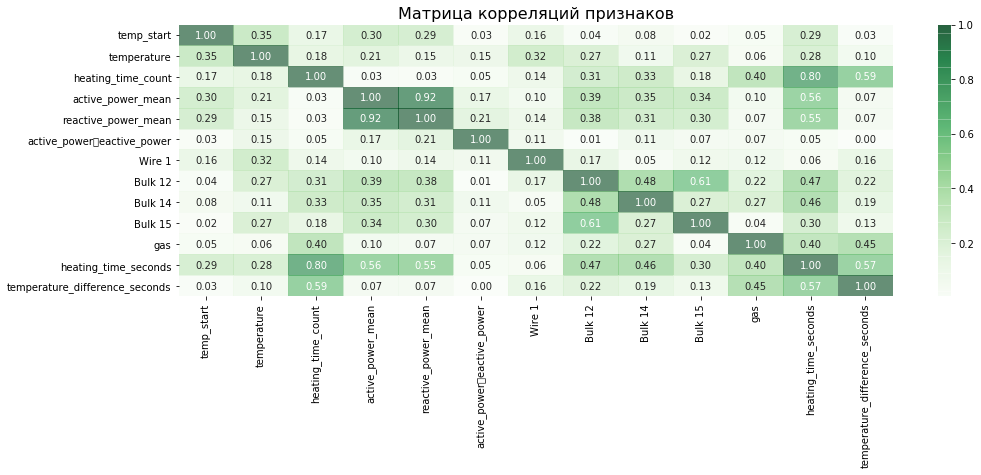

In [49]:
plt.figure(figsize=(16, 5))
sns.heatmap(model_fin_table[[
    'temp_start', 'temperature', 
    'heating_time_count', 'active_power_mean', 
    'reactive_power_mean', 'active_power\reactive_power', 
    'Wire 1', 'Bulk 12', 'Bulk 14', 'Bulk 15', 'gas', 
    'heating_time_seconds', 'temperature_difference_seconds'    
]].corr().abs(), cmap='Greens', alpha=0.6,
           annot=True, fmt='.2f'
           );
plt.title('Матрица корреляций признаков', fontsize=16)
plt.show()

Из полученной таблицы можем видеть сильную коррелирующую зависимость двух мощностей (активной и реактивной), а так же время нагрева в секундах от количества запусков нагрева электродами, при дальнейшем обучении моделей на этих данных они могут мешать и модели могут давать неточные прогнозы. Но для того, чтобы понять какие данные стоит оставить, а какие нет мы посмотрим на график важности наилучшей модели.

Вывод:

Данные предобработаны, с пропущенными значениями и аномалиями разобрались, все необходимые признаки собрали в финальную таблицу. Вперед к обучению модели!

# Обучение модели

## Выделим тестовую и тренировочную выборки 

Данные были подготовлены для обучения модели.   
Выделим целевой признак конечной температуры 'temperature'. Остальные же столбцы, или фичи, будут использованы для предсказания.   
Разобьем данные на train и test к соотношению 75/25. 

In [50]:
f = model_fin_table.drop(columns='temperature')
t = model_fin_table['temperature']

In [51]:
f_train, f_test, t_train, t_test = train_test_split(f, t, test_size=0.25, random_state=42, shuffle=True)

In [52]:
train_sample=f_train.shape[0]/f.shape[0]
test_sample=f_test.shape[0]/f.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(train_sample))
print('Размер тестовой выборки - {:.0%}'.format(test_sample))

Размер тренировочной выборки- 75%
Размер тестовой выборки - 25%


Выберем следующие модели для задачи регрессии:

DecisionTreeRegressor  
LinearRegression  
GradientBoostingRegressor  
CatBoostRegressor

Создадим функцию, которая будет выводить график зависимости предсказанных значений от истинных, и метрики качества предсказаний. 

In [53]:
def graph(name,predict):
    plt.figure(figsize=(8,8))
    sns.regplot(x=t_test, y=predict)
    plt.title('График распределения зависимости предсказанных от истинных значений', y=1.01)
    plt.ylabel('Предсказанные значения')
    plt.xlabel('Истинные значения')
    plt.show()

    print('MAE модели '+ name,': %.2f' % mean_absolute_error(t_test, predict))
    print('RMSE модели '+ name,': %.2f' % (mean_squared_error(t_test, predict))**0.5)

### DecisionTreeRegressor

В качестве алгоритма предсказания целевого признака начнем с модели решающего дерева. Кросс-валидация будет заложена в GridSearch с помощью параметра cv=5. Обучим модель, найдем параметры, посчитаем МАE на тренировочной выборке, а затем и на тестовой, вместе со значением RMSE.

In [54]:
parametrs_r = { 'max_depth': range (1,10),
               'min_samples_leaf': range (1,5)}
model_d = DecisionTreeRegressor(random_state=12345)  
grid_dt = GridSearchCV(model_d, parametrs_r, cv=5, scoring='neg_mean_absolute_error')
grid_dt.fit(f_train,t_train)
best_score_dt = -1*grid_dt.best_score_
parametrs_dt = pd.Series(grid_dt.best_params_)[0]
predict_dt=grid_dt.predict(f_test)
print('Значение MAE на тренировочных данных равно: {:.2f}'.format(best_score_dt), '\nМаксимальная глубина:',parametrs_dt)

Значение MAE на тренировочных данных равно: 5.64 
Максимальная глубина: 7


In [55]:
mae_dt= mean_absolute_error(t_test, predict_dt).round(2)
rmse_dt= (mean_squared_error(t_test, predict_dt)**0.5).round(2)

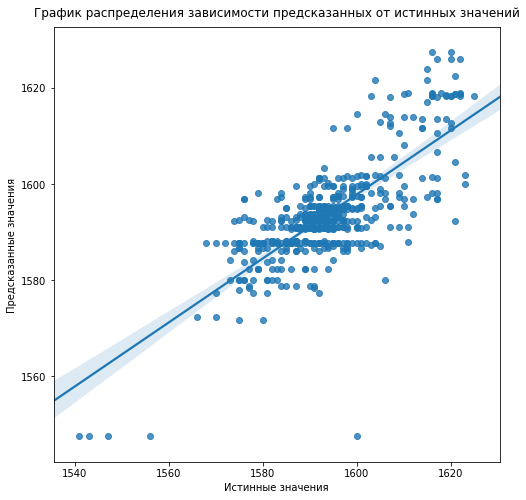

MAE модели DecisionTreeRegressor : 5.34
RMSE модели DecisionTreeRegressor : 7.51


In [56]:
graph('DecisionTreeRegressor',predict_dt)

### LinearRegression

Аналогично предыдущему пункту обучим модель LinearRegression, посчитаем МАЕ на тренировочной и тестовой выборках.

In [57]:
parametrs = { 'fit_intercept': [True],
              'normalize': [True, False]}

model_lr = LinearRegression()
grid_lr = GridSearchCV(model_lr, parametrs, cv=5, scoring='neg_mean_absolute_error')
grid_lr.fit(f_train,t_train)

fit_intercept=pd.Series(grid_lr.best_params_)[0]
normalize=pd.Series(grid_lr.best_params_)[1]
predict_lr=grid_lr.predict(f_test)
result_lr = -1*grid_lr.best_score_
print('Значение MAE на тренировочных данных равно: {:.2f}'.format(result_lr))

Значение MAE на тренировочных данных равно: 5.74


In [58]:
mae_lr= mean_absolute_error(t_test, predict_lr).round(2)
rmse_lr= (mean_squared_error(t_test, predict_lr)**0.5).round(2)

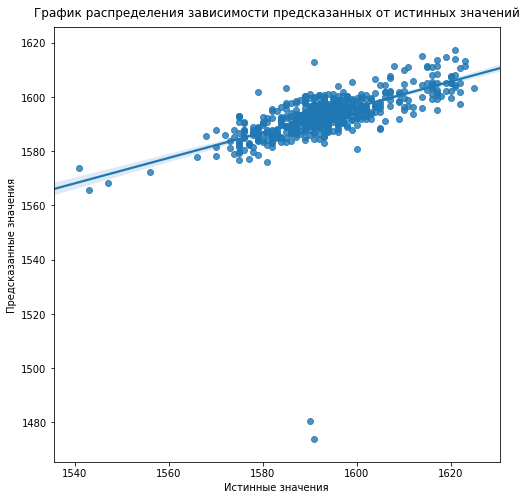

MAE модели LinearRegression : 6.06
RMSE модели LinearRegression : 10.04


In [59]:
graph('LinearRegression',predict_lr)

### GradientBoostingRegressor

In [60]:
parametrs_g = { 'loss' : ['ls'],
        'learning_rate' : [i for i in np.arange(0.1,0.3,0.1)] , 
        'max_depth' : [i for i in np.arange(10,15,1)]}

model_g = GradientBoostingRegressor(random_state = 123)
grid_gbr = GridSearchCV(model_g, parametrs_g, cv=5, scoring = 'neg_mean_absolute_error')
grid_gbr.fit(f_train,t_train)
best_score_gbr = -1*grid_gbr.best_score_
parametrs_gbr = pd.Series(grid_gbr.best_params_)[0]
predict_gbr=grid_gbr.predict(f_test)
print('Значение MAE на тренировочных данных равно: {:.2f}'.format(best_score_gbr))

Значение MAE на тренировочных данных равно: 4.90


In [61]:
mae_gbr= mean_absolute_error(t_test, predict_gbr).round(2)
rmse_gbr= (mean_squared_error(t_test, predict_gbr)**0.5).round(2)

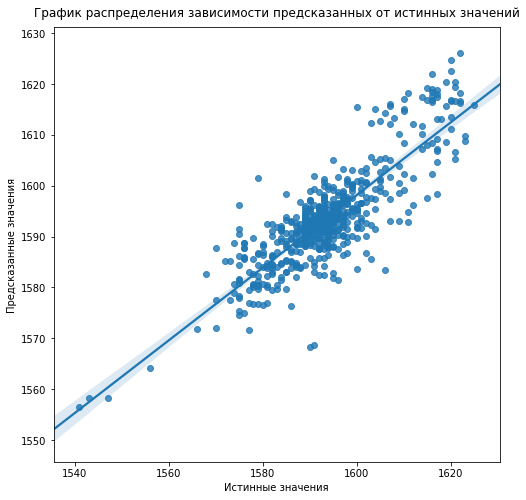

MAE модели GradientBoostingRegressor : 4.51
RMSE модели GradientBoostingRegressor : 6.14


In [62]:
graph('GradientBoostingRegressor',predict_gbr)

### CatBoostRegressor

In [63]:
model = CatBoostRegressor(iterations=1000, depth=2, loss_function="MAE", verbose=100)
model.fit(f_train,t_train, eval_set=(f_test,t_test))

0:	learn: 7.9826966	test: 8.0485925	best: 8.0485925 (0)	total: 48.2ms	remaining: 48.2s
100:	learn: 5.8419697	test: 6.0838951	best: 6.0838951 (100)	total: 653ms	remaining: 5.81s
200:	learn: 5.2159361	test: 5.5162544	best: 5.5162544 (200)	total: 1.33s	remaining: 5.28s
300:	learn: 4.8821282	test: 5.2402821	best: 5.2402821 (300)	total: 2s	remaining: 4.66s
400:	learn: 4.6467281	test: 5.0458280	best: 5.0458280 (400)	total: 2.76s	remaining: 4.13s
500:	learn: 4.4768192	test: 4.9044549	best: 4.9044549 (500)	total: 3.43s	remaining: 3.41s
600:	learn: 4.3557880	test: 4.8329822	best: 4.8318419 (599)	total: 4.1s	remaining: 2.72s
700:	learn: 4.2530246	test: 4.7709688	best: 4.7709688 (700)	total: 4.6s	remaining: 1.96s
800:	learn: 4.1623438	test: 4.7213681	best: 4.7213681 (800)	total: 5.36s	remaining: 1.33s
900:	learn: 4.0826202	test: 4.6738675	best: 4.6738587 (899)	total: 6.04s	remaining: 663ms
999:	learn: 4.0196785	test: 4.6308379	best: 4.6305996 (990)	total: 6.7s	remaining: 0us

bestTest = 4.6305996

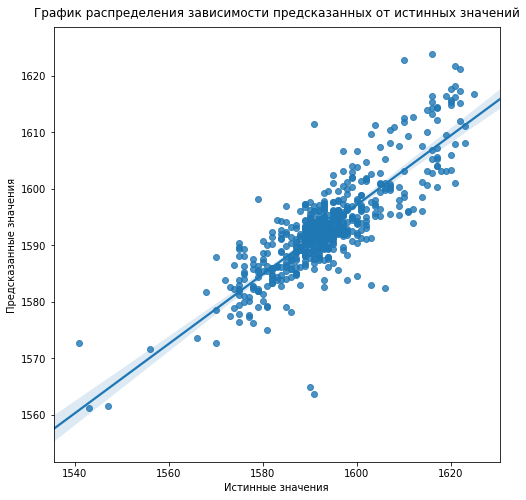

MAE модели CatBoostRegressor : 4.63
RMSE модели CatBoostRegressor : 6.43


In [64]:
predict_cat=model.predict(f_test)
graph('CatBoostRegressor',predict_cat)

А теперь найдём факторы важности наилучшей модели, и посмотрим, какие признаки могут быть лишними, и которые мы удалим.

In [65]:
def importances(model,features):
    features=features.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(11, 5))
    plt.title('Важность функции')
    plt.barh(range(len(indices)), importances[indices], color='#6495ED', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Важность функции')
    plt.show()
        
    feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
    feat_importances = feat_importances.to_frame()
    feat_importances.columns=['Важность функции']
    display(feat_importances)

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


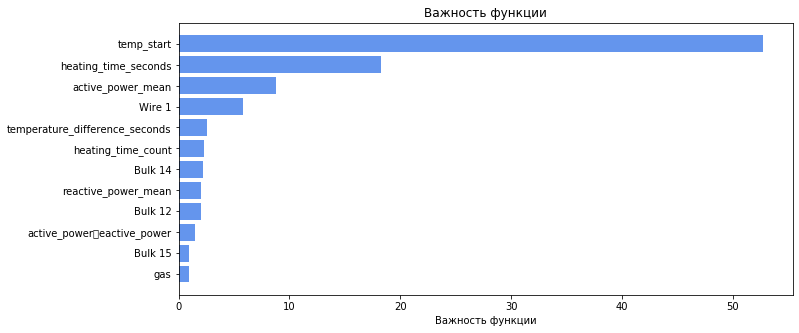

,Важность функции
temp_start,52.761020
heating_time_seconds,18.281335
active_power_mean,8.777744
Wire 1,5.826735
temperature_difference_seconds,2.511171
heating_time_count,2.326633
Bulk 14,2.229538
reactive_power_mean,2.031501
Bulk 12,1.988620
active_power\reactive_power,1.443527


In [66]:
importances(model,f_test)

Исходя из графика относительной важности факторов, мы можем удалить такие признаки как gas и reactive_power_mean (средняя реактивная мощность), так как эот признак сильно коррелирует, а средняя активная мощность имеет больший вес, большую важность, в предсказании данных. 

Создадим копии нашего целевого признака и фичей, а затем удалим, описанные выше, признаки. 

In [67]:
f_train2 = f_train.copy()
f_test2= f_test.copy()
f_train2 = f_train2.drop(columns=['gas', 'reactive_power_mean'])
f_test2= f_test2.drop(columns=['gas', 'reactive_power_mean'])
f_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 1680 to 923
Data columns (total 10 columns):
temp_start                        1746 non-null float64
heating_time_count                1746 non-null float64
active_power_mean                 1746 non-null float64
eactive_power        1746 non-null float64
Wire 1                            1746 non-null float64
Bulk 12                           1746 non-null float64
Bulk 14                           1746 non-null float64
Bulk 15                           1746 non-null float64
heating_time_seconds              1746 non-null float64
temperature_difference_seconds    1746 non-null float64
dtypes: float64(10)
memory usage: 150.0 KB


Проверим эти данные на моделях, которые показали наилучший результат до того, как мы дропнули наименее важные признаки.

Модели **GradientBoostingRegressor и CatBoostRegressor**. 

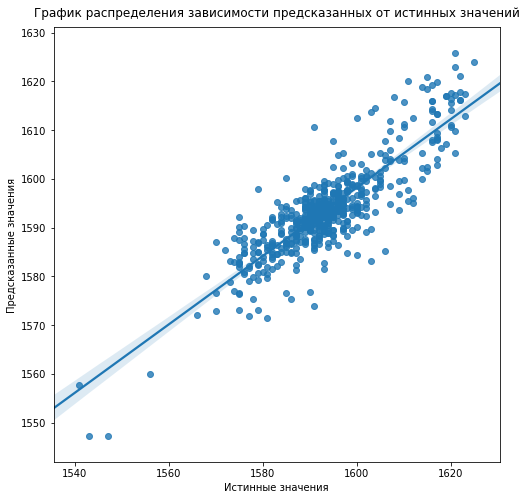

MAE модели GradientBoostingRegressor : 4.41
RMSE модели GradientBoostingRegressor : 5.91


In [68]:
model_gbr = GradientBoostingRegressor (random_state = 12345) 
model_gbr.fit(f_train2,t_train)
predict_gbr=model_gbr.predict(f_test2)
graph('GradientBoostingRegressor',predict_gbr)

In [69]:
mae_gbr= mean_absolute_error(t_test, predict_gbr).round(2)
rmse_gbr= (mean_squared_error(t_test, predict_gbr)**0.5).round(2)

0:	learn: 7.9771983	test: 8.0385068	best: 8.0385068 (0)	total: 1.9ms	remaining: 1.9s
100:	learn: 5.8104336	test: 6.0416209	best: 6.0416209 (100)	total: 724ms	remaining: 6.45s
200:	learn: 5.1908239	test: 5.4701809	best: 5.4701809 (200)	total: 1.4s	remaining: 5.56s
300:	learn: 4.8492898	test: 5.1802655	best: 5.1802655 (300)	total: 2.15s	remaining: 5.01s
400:	learn: 4.6009021	test: 4.9401029	best: 4.9401029 (400)	total: 2.92s	remaining: 4.37s
500:	learn: 4.4433071	test: 4.8165276	best: 4.8165276 (500)	total: 3.69s	remaining: 3.68s
600:	learn: 4.3227961	test: 4.7387417	best: 4.7387417 (600)	total: 4.47s	remaining: 2.97s
700:	learn: 4.2337958	test: 4.6865904	best: 4.6865904 (700)	total: 5.15s	remaining: 2.2s
800:	learn: 4.1440710	test: 4.6424763	best: 4.6424763 (800)	total: 5.72s	remaining: 1.42s
900:	learn: 4.0838616	test: 4.5962055	best: 4.5962055 (900)	total: 6.4s	remaining: 704ms
999:	learn: 4.0378820	test: 4.5650426	best: 4.5645135 (996)	total: 7s	remaining: 0us

bestTest = 4.564513467

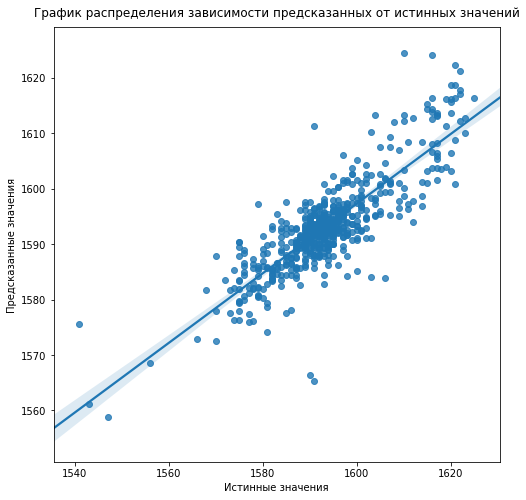

MAE модели CatBoostRegressor : 4.56
RMSE модели CatBoostRegressor : 6.31


In [70]:
model = CatBoostRegressor(iterations=1000, depth=2, loss_function="MAE", verbose=100)
model.fit(f_train2,t_train, eval_set=(f_test2,t_test))
predict_cat=model.predict(f_test)
graph('CatBoostRegressor',predict_cat)

In [71]:
mae_cat= mean_absolute_error(t_test, predict_cat).round(2)
rmse_cat= (mean_squared_error(t_test, predict_cat)**0.5).round(2)

Итак, соберем все наши полученные данные в таблицу и найдем самую лучшую модель.

In [72]:
column=['MAE']
comparison_tabl = pd.DataFrame(index=['DecisionTreeRegressor','LinearRegression', 'GradientBoostingRegressor', 'CatBoostRegressor'], columns=['RMSE','MAE'])
comparison_tabl['MAE'] = mae_dt,mae_lr, mae_gbr, mae_cat
comparison_tabl['RMSE'] = rmse_dt,rmse_lr,rmse_gbr, rmse_cat

comparison_tabl.style.highlight_min(color='yellowgreen',subset=column).highlight_null(null_color='lightgrey').highlight_max(color='coral',subset=column)

,RMSE,MAE
DecisionTreeRegressor,7.51,5.34
LinearRegression,10.04,6.06
GradientBoostingRegressor,5.91,4.41
CatBoostRegressor,6.31,4.56


## Вывод 

Мы использовали обработанные данные и обучили четыре модели DecisionTreeRegressor,LinearRegression, GradientBoostingRegressor и CatBoostRegressor.  
По итогам сравнения метрик качества предсказаний из четырех моделей лидируют GradientBoostingRegressor и CatBoostRegressor, которые достигли значений в $4.41$ и  $4.56$ соответственно по метрике $MAE$. Этот результат показывает, что модель в среднем ошибается на 4-5 градусов температуры. 
Таким образом, мы выполнили задачу и достигли требуемого значения $MAE <6.00$, а так же дополнительно выяснили наиболее важные данные на которых строилось предсказание наших наилучших моделей, ТОП-3 из которых это "temp_start, heating_time_seconds, active_power_mean", то есть температура в начале замера, время нагрева в секундах и средняя активная мощность. 

# Отчет по решению 

Перед нами стояла задача оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» на этапе обработки стали. Для этого нам предстояло построить модель, которая предскажет температуру стали в последней точке измерения (целевой признак) имея данные об электродах, о подаче сыпучих материалов (объём и время), о продувке сплава газом, результаты измерения температуры и данные о проволочных материалах (объём и время). Целью поставлена метрика $MAE$ со значением $< 6.00$

В ходе проделанной работы были выполнены все этапы плана: предобработка данных, исследовательский анализ данных, обучение и выбор моделей.

Для обучения модели необходимо было объединить имеющиеся таблицы в одну финальную. Добавление проволочных материалов оказывает минимальное влияние на процесс поэтому было решено оставить только Wire 1, так как проволочные материалы этой группы используются чаще всего и смогут помочь модели обучиться. 
Сыпучие материалы поступающие из бункеров 12, 14, 15 используются наиболее часто, имеют выраженную мультиколлинеарность между собой, остальные сыпучие материалы мало влияют на процесс, поэтому было решено забрать в фичи именно эти присыпки. 
Более 700 записей в датасете имеют только одно измерение температуры. От них мы тоже отказались и удалили, так как грамотно заменить эти "пропуски" просто невозможно. 

Информация о времени начала и конца нагрева сплава, а также активная и реактивная мощности содержалась в таблице data_arc. Было принято решение в финальной таблице отказаться от временных признаков, так как они не решают никакую бизнес задачу и не нужны для обучения модели, но были выделены дополнительные признаки, о которых напишем чуть ниже. Активная и реактивная мощности показали выраженную мультиколлинеарность, но избавились от одной из них (реактивной) только после графика относительной важности факторов для обучения модели. 

В ходе решения задачи в исходные данные были добавлены новые признаки, на основе которых модель сможет лучше предсказывать целевое значение по темпратуре. Были добавлены дополнительные столбцы: длительность времени между первым и последним замером температуры, суммарное время нагрева электродами, количество запусков нагрева электродами, среднее соотношение потребления активной и реактивной мощности.

В финальный датафрейм была включена следующая информация: 
- 'temp_start' - температура в начале замера,
- 'temperature' - температура в конце замера,
- 'heating_time_count' - количество запусков нагрева электродами, 
- 'active_power_mean' - средняя активная мощность, 
- 'reactive_power_mean' -  средняя реактивная мощность, 
- 'active_power\reactive_power' - среднее соотношение потребления активной и реактивной мощностей, 
- 'Wire 1' - данные о проволочных материалах, 
- 'Bulk 12', 'Bulk 14', 'Bulk 15' - данные о сыпучих материалах, 
- 'gas' - данные о продувке сплава газом, 
- 'heating_time_seconds' - суммарное время нагрева электродами, 
- 'temperature_difference_seconds' - длительность времени между первым и последним замером температуры. 

В данных были удалены дубли, отрицательные значения мощностей, аномалии, были обработаны пропущенные значения. Было проведено исследование на наличие мультиколлинеарности в данных финального датафрейма, в ходе которого обнаружилась сильная коррелирующую зависимость двух мощностей (активной и реактивной), а также время нагрева в секундах от количества запусков нагрева электродами. После проделанных этапов, описанных выше, данные были очищены и готовы для построения модели предсказания конечной температуры сплава "temperature". 
   
Для нахождения наилучего качества в предсказании мы обучили четыре модели DecisionTreeRegressor, LinearRegression, GradientBoostingRegressor и CatBoostRegressor и сравнили их показатели по двум метрикам $MAE$, $RMSE$. Сравнив показатели метрик остановились на GradientBoostingRegressor и CatBoostRegressor, у которых $MAE$ было равно $4.51$ и $4.63$ соответственно. Далее вывели на график важности основные группы данных, на котором определили лишние данные и исключили коррелирующую среднюю реактивную мощность из таблицы, после чего обучили выбранные наилучшие модели на более очищенных данных, тем самым улучшив показание метрики $MAE$ до $4.41$ и $4.56$. 

А так же на графике важности заметили, что основное влияние на предсказание модели влияет темпратура в начале измерения и время нагрева, а это значит, что вероятнее всего влияя на величину начальной темпратуры можно достигнуть цели по оптимизации производственных расходов на энергоресурсы.

**Какие пункты плана были выполнены, а какие — нет (поясните почему)?**

Были выполнены все пункты плана, кроме выявления пулла подходов с помощью lazypredict, который помог бы сразу найти регрессионную модель, удовлетворяющую необходимым характеристикам. Не удалось выполнить этот пункт плана, так как нужна версия  > Python 3.6. Пришлось потратить много времени и тщетных попыток прежде, чем понять это. 
В остальном все пункты плана были аналогичны прошлым спринтам и не составили труда реализовать их. 

**Какие трудности возникли и как вы их преодолели?**

Для начала было сложно разобраться в самом процессе плавки стали, и что за чем следует. Помогла схема расписанная от руки + первая консультация с тимлидом, который еще лучше все разжевал и рассказал про требования заказчика. Но до сих пор думаю, что я не так глубоко поняла тему, что лишило меня возможности еще лучше поработать с аномалиями, выбросами и пропущенными значениями. 

**Какие ключевые шаги в решении задачи выделили?**

Понимание процесса плавления стали,   
Изучение данных, их структуры и необходимости для решения поставленной задачи,   
А также работа с данными, пропущенными значениями и аномалиями,   
Подготовка и построение модели,   
Тестирование модели и проверка ее на адекватность. 

**Какая ваша итоговая модель и какое у неё качество?**

Модель построена с помощью GradientBoostingRegressor со значением МАЕ $4.41$ на тестовой выборке. 